In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 2.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=762b73669b8f76bd6c59c04fd37230f8e7ba730977f30890a874dedb3b37ac6b
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


#Importing library 

In [ ]:

import tarfile
from torchvision.datasets.utils import download_url
import torchvision.transforms as tt
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.metrics import f1_score,confusion_matrix
import os
import torch
import wandb
import torch.nn as nn
import scipy.io
import numpy as np

#wandb initialization

In [ ]:

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="CV_A1_Q1", entity="iiitd",name='Q1_part1-1')

wandb: Currently logged in as: manvendra (iiitd). Use `wandb login --relogin` to force relogin


#Download dataset

In [ ]:
train_url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
download_url(train_url, '.')

  0%|          | 0/182040794 [00:00<?, ?it/s]

In [ ]:
test_url = 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'
download_url(test_url, '.')

  0%|          | 0/64275384 [00:00<?, ?it/s]

#loading and transforming data

In [ ]:
trans = tt.Compose([
    tt.ToTensor()
])


In [ ]:
class DataSet:
  def __init__(self,path,transform = None):
    self.raw = scipy.io.loadmat(path)
    self.X = self.raw['X'].transpose()
    self.y = self.raw['y']
    self.transform = transform
  
  def __getitem__(self,index):
    img = self.X[index]
    if self.transform is not None:
        img = self.transform (img).permute(1, 0,2)
    label = self.y[index]
    if label[0] ==10:
      label = [0]
    return img , label[0]
    

  def __len__(self):
    return self.y.shape[0]


In [ ]:
train_path = r'/content/train_32x32.mat'
#test_path = r'/content/test_32x32.mat'
data = DataSet(train_path,trans)
#test = DataSet(test_path,trans)

In [ ]:
len(data)

73257

In [ ]:
test_size = int(len(data)*0.1)
val_size = int(len(data)*0.2)
temp_train_size =len(data)-test_size
train_size = len(data)-test_size-val_size

train_ds_temp, test_ds = random_split(data, [temp_train_size, test_size])
train_ds, val_ds = random_split(train_ds_temp, [train_size, val_size])
print(len(train_ds), len(val_ds),len(test_ds))

51281 14651 7325


In [ ]:
batch =256

In [ ]:
train_dl = DataLoader(train_ds, batch, shuffle=True, num_workers=3)
val_dl = DataLoader(val_ds, batch, shuffle=True, num_workers=3)
test_dl = DataLoader(test_ds, len(test_ds), shuffle=True, num_workers=3)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from collections import Counter
train_class={i:0 for i in range(0,10)}
for _, label in train_dl:
  for j in label:
    train_class[j.item()]+=1



#class distribution and visualization 

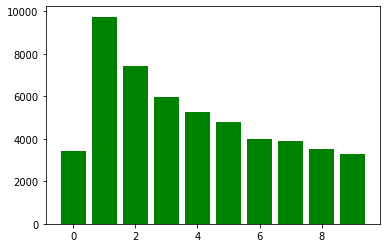

In [ ]:
plt.bar(list(train_class.keys()), train_class.values(), color='g')
plt.show()

In [ ]:

test_class={i:0 for i in range(10)}
for _, label in test_dl:
  for j in label:
    test_class[j.item()]+=1



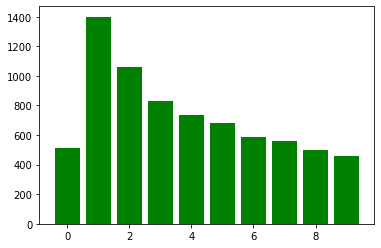

In [ ]:
plt.bar(list(test_class.keys()), test_class.values(), color='g')
plt.show()

In [ ]:
from torchvision.utils import make_grid
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, label in dl:
        print(label[:64])
        show_images(images, nmax)
        break

tensor([4, 1, 4, 3, 1, 5, 7, 0, 4, 3, 9, 9, 8, 3, 2, 1, 2, 4, 3, 2, 7, 9, 1, 2,
        9, 7, 3, 5, 3, 1, 3, 4, 8, 3, 2, 3, 4, 5, 7, 2, 4, 3, 6, 9, 4, 3, 5, 9,
        8, 1, 9, 7, 2, 8, 6, 0, 7, 4, 2, 1, 1, 7, 5, 1])


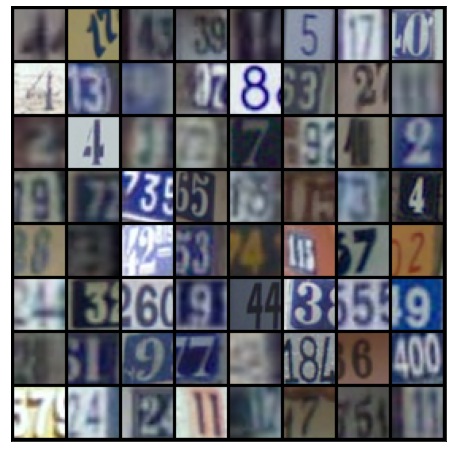

In [ ]:
show_batch(train_dl,64)

#GPU loader 

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
train_dl = DeviceDataLoader(train_dl,'cuda')
val_dl = DeviceDataLoader(val_dl,'cuda')

#Defining Neural Network and Helper function

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == (labels)).item() / len(preds))


class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d( 3, 32, kernel_size = 3, padding = 1, stride=1),
        nn.ReLU(),
        nn.Conv2d( 32, 64, kernel_size = 3, padding = 1, stride=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(65536,10),
        nn.ReLU()
    ) 
  def forward(self, x):
    return self.network(x)
  
  def train_step(self,batch):
      img , label = batch
      pred = self(img)
      loss = F.cross_entropy(pred,label)
      return loss
  
  def valid_step(self,batch):
      img , label = batch
      pred = self(img)
      loss = F.cross_entropy(pred, label)  
      acc = accuracy(pred, label)
      return {'acc':acc , 'loss':loss.item()}

  def valid_metric_cals(self,output):
    loss = [i['loss'] for i in output]
    acc = [i['acc'] for i in output]
    valid_loss = np.mean(loss)
    valid_acc = np.mean(acc)
    return {'val_loss':valid_loss,'valid_acc':valid_acc}
  
  def epoch_end(self, epoch_no , result):
    wandb.log({ 'epoch' : epoch_no+1, 'training loss': result["train_loss"], 'validation loss': result["val_loss"], 'accuracy': result["valid_acc"]})
    print(f'epoch :{epoch_no+1}, training loss: {result["train_loss"]}, validation loss: {result["val_loss"]}, accuracy: {result["valid_acc"]}')

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
@torch.no_grad()
def evalu(model, val_dl):
  model.eval()
  temp = [ model.valid_step(j) for j in val_dl ]
  return model.valid_metric_cals(temp)

def fit(train_dl,val_dl,model,lr,optim,epochs):
  history = []
  optimizer =  optim(model.parameters(),lr=lr)
  
  for epoch in range(epochs):
    train_loss = []
    model.train()
    for batch in tqdm(train_dl):
      optimizer.zero_grad()
      loss = model.train_step(batch)
      loss.backward()
      train_loss.append(loss.item())
      optimizer.step()
      
    result = evalu(model,val_dl)
    result['train_loss'] = np.mean(train_loss)
    history.append(result)
    model.epoch_end(epoch,result)
  return history

    

#Traning model

In [ ]:
model = Model()

model = to_device(model,'cuda')
lr = 0.008
optimizer= torch.optim.SGD
epochs=10
wandb.config = {'lr':lr,'optimuzer':'SGD','epochs':epochs,'batch_size':batch}

In [ ]:
wandb.watch(model)
history=fit(train_dl,val_dl,model,lr,optimizer,epochs)

  0%|          | 0/201 [00:00<?, ?it/s]

epoch :1, training loss: 2.247088853399552, validation loss: 2.243722048299066, accuracy: 0.1855514496564865


  0%|          | 0/201 [00:00<?, ?it/s]

epoch :2, training loss: 2.2392884202264436, validation loss: 2.241003287249598, accuracy: 0.1855514496564865


  0%|          | 0/201 [00:00<?, ?it/s]

epoch :3, training loss: 2.2357360035625855, validation loss: 2.2380161490933648, accuracy: 0.19125328958034515


  0%|          | 0/201 [00:00<?, ?it/s]

epoch :4, training loss: 2.2313073665941534, validation loss: 2.2335300568876595, accuracy: 0.19574514031410217


  0%|          | 0/201 [00:00<?, ?it/s]

epoch :5, training loss: 2.221783760175183, validation loss: 2.2271897094003084, accuracy: 0.21498414874076843


  0%|          | 0/201 [00:00<?, ?it/s]

epoch :6, training loss: 2.2104395515290065, validation loss: 2.208641056356759, accuracy: 0.21523186564445496


  0%|          | 0/201 [00:00<?, ?it/s]

epoch :7, training loss: 2.1965335459258424, validation loss: 2.192576733128778, accuracy: 0.22382745146751404


  0%|          | 0/201 [00:00<?, ?it/s]

epoch :8, training loss: 2.1749035398758467, validation loss: 2.1756859894456535, accuracy: 0.24259844422340393


  0%|          | 0/201 [00:00<?, ?it/s]

epoch :9, training loss: 2.139493034846747, validation loss: 2.137676711740165, accuracy: 0.2580191195011139


  0%|          | 0/201 [00:00<?, ?it/s]

epoch :10, training loss: 2.0756111696584902, validation loss: 2.0434210608745444, accuracy: 0.3171539306640625


#Saving model

In [ ]:
torch.save(model.state_dict(),"model.pth")
artifact  = wandb.Artifact('model',type = 'model')
artifact.add_file('model.pth')
wandb.log_artifact(artifact)

In [ ]:
wandb.finish()

accuracy,▁▁▁▂▃▃▃▄▅█
epoch,▁▂▃▃▄▅▆▆▇█
training loss,███▇▇▇▆▅▄▁
validation loss,████▇▇▆▆▄▁
accuracy,0.31715
epoch,10
training loss,2.07561
validation loss,2.04342


In [ ]:
wandb.init(entity="iiitd",name="meta_data",project="CV_A1_Q1",id='megyjsdz', resume="must",settings=wandb.Settings(start_method="thread"))


In [ ]:
artifact = wandb.use_artifact(r'iiitd/CV_A1_Q1/model:v2',type='model')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [ ]:
artifact_dir

'./artifacts/model:v2'

#Loading model

In [ ]:
model = to_device(Model(),'cuda')
state_dict = torch.load( artifact_dir +'/model.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

# Computing F1 score and Accuracy score on testset

In [ ]:
from sklearn.metrics import f1_score,accuracy_score

test_dl = DeviceDataLoader(test_dl,'cuda')
@torch.no_grad()
def test_accuracy_f1(test_dl):
  model.eval()
  acc=0
  f1=0
  confusion_m = np.zeros((10,10),dtype=int)

  for num,(img,label) in enumerate(test_dl):
    outputs = model(img)
    batchs_report = []
    _, pred = torch.max(outputs, dim=1)
    predx,labelx = (pred.cpu().clone().numpy(),label.cpu().clone().numpy())
    f1=f1_score(labelx,predx,average='macro')
    acc=accuracy_score(labelx,predx)
    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labelx, preds=predx,
                        )})
    break
  wandb.log({'f1_score':f1,'accuracy_score':acc})
  return f'f1 Score: {f1}', f'Accuracy: {acc}'
score_rate = test_accuracy_f1(test_dl)
print(score_rate)



('f1 Score: 0.011361516726115448', 'Accuracy: 0.012559726962457338')


In [ ]:
wandb.finish()

accuracy_score,▁
f1_score,▁
accuracy,0.31715
accuracy_score,0.01256
epoch,10
f1_score,0.01136
training loss,2.07561
validation loss,2.04342


# Visualising Mis-Classified image

In [ ]:
@torch.no_grad()
def false_image_list(test_dl):
  model.eval()
  img_list = [[] for i in range(10)]
  for num,(img,label) in enumerate(test_dl):
    outputs = model(img)
    batchs_report = []
    _, pred = torch.max(outputs, dim=1)
    predx,labelx = (pred.cpu().clone().numpy(),label.cpu().clone().numpy())
    #print(np.where([predx != labelx]))
    for i in np.where([predx != labelx])[1]:
      img_list[labelx[i]].append((img[i].cpu().clone().permute(1,2,0).numpy(),predx[i]))
    break
    
  return img_list
img_liz =false_image_list(test_dl)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(img_liz[0])

500

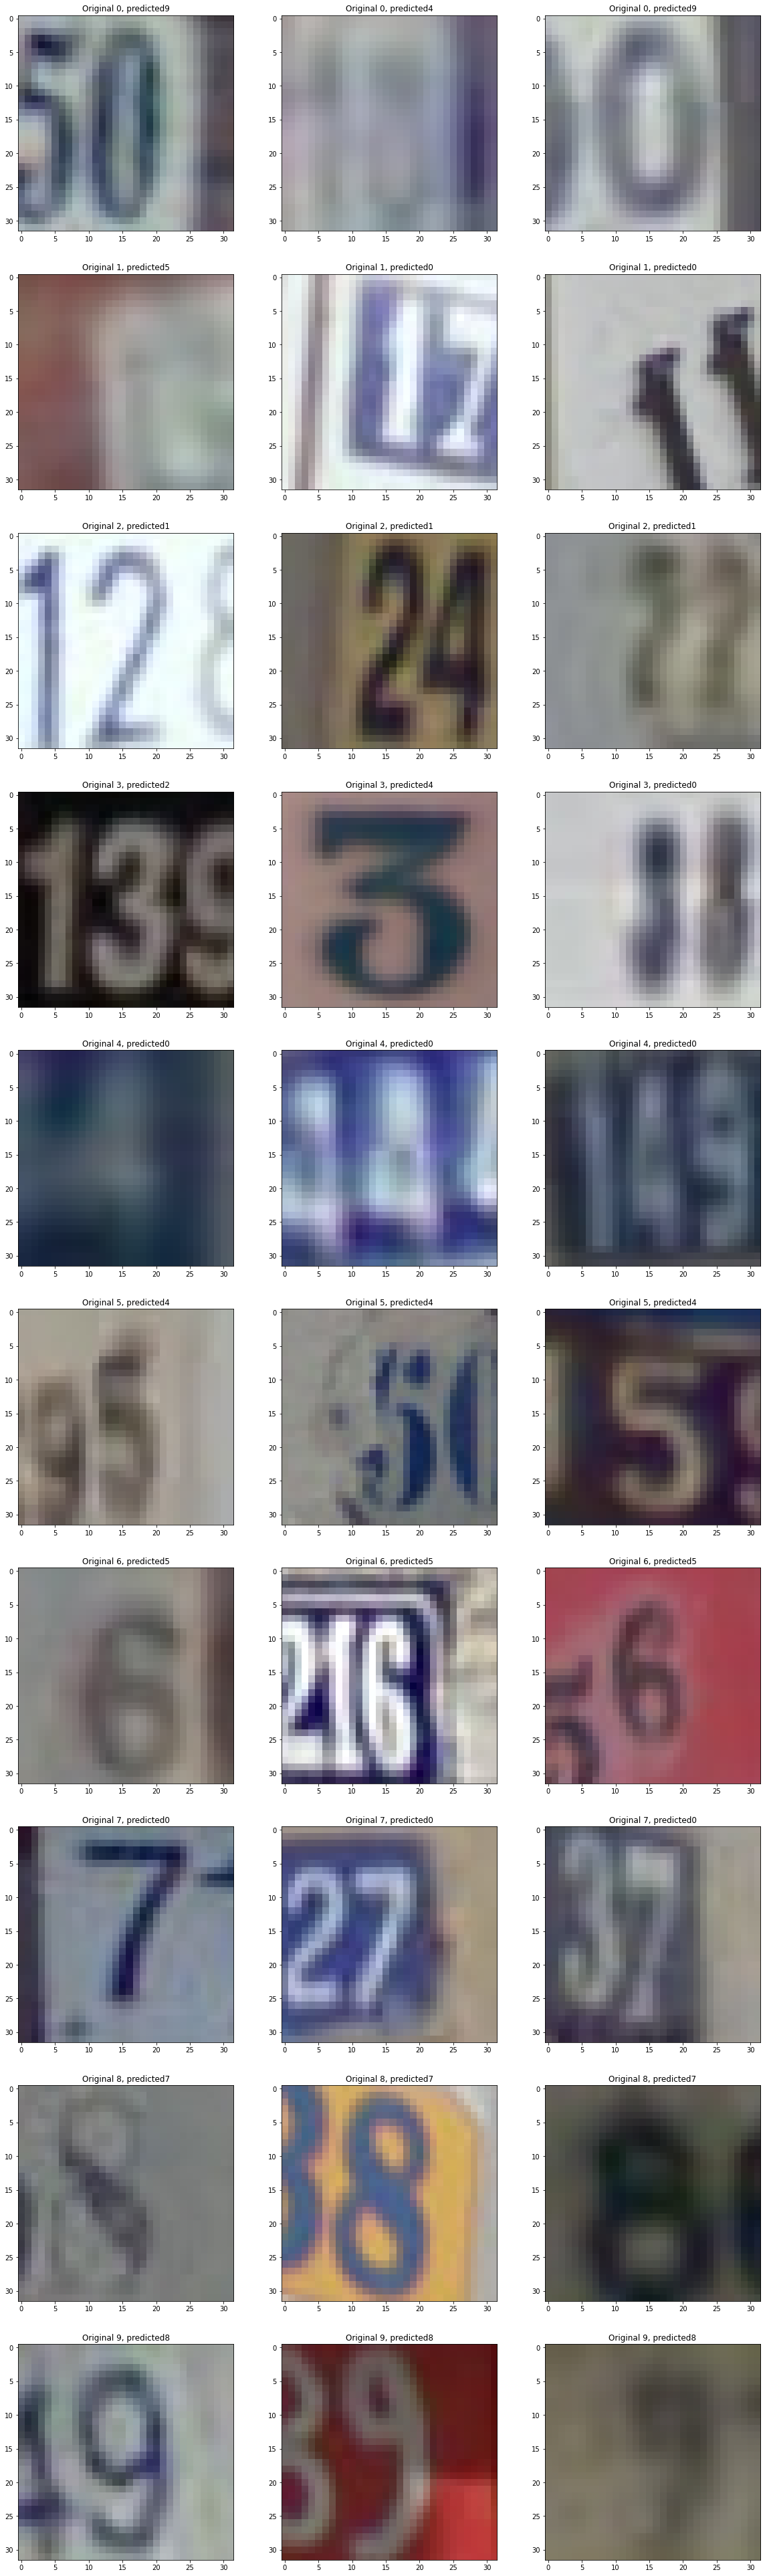

In [ ]:
figure, axis = plt.subplots(10, 3, figsize=(20,70))
# fig = plt.figure()
for label,img_pred in enumerate(img_liz):
  count = 0
  for (img,pred) in img_pred:
    if count==3:
      break
    axis[label,count].imshow(img)
    axis[label,count].title.set_text(f'Original {label}, predicted{pred}')

    # ax = fig.add_subplot(100+label+count)
    # ax.imshow(img)
    #ax.title.set_text(f'Original {label}, predicted{pred}')

    count+=1
  
  #   if count ==3:
  #     break
  #   print(pred)
  #   plt.imshow(img)
  #   count+=1
  # plt.show()



Few of the images are far too noisey  and hence can not be predicted.Others have multiple number which causes confusion.